<a href="https://colab.research.google.com/github/anacrm00/Test/blob/main/Solar_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Solar power prediction with KNN**

---



**Importing necessary libraries**

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

**Data exploration**

First, the data set is imported and stored:

In [27]:
url = ("https://raw.githubusercontent.com/anacrm00/Solar/main/Pasion_et_al_dataset3.csv")
solar = pd.read_csv(url, header=None)

We add the name of the columns and rearrange them for easier manipulation:

In [28]:
solar.columns = ["Location", "Date", "Time", "Latitude", "Longitude","Altitude","YRMODAHRMI", "Month", "Hour", "Season", "Humidity", 
                 "AmbientTemp","PolyPwr", "Wind.Speed", "Visibility","Pressure", "Cloud.Ceiling"]

solar = solar.reindex(columns=["PolyPwr","Location", "Date", "Time", "Latitude", "Longitude","Altitude","YRMODAHRMI", "Month", "Hour", "Season", "Humidity", 
                 "AmbientTemp", "Wind.Speed", "Visibility","Pressure", "Cloud.Ceiling"])

We can generate the histogram for our target variable PolyPwr, to get an overview of the range of power we can expect

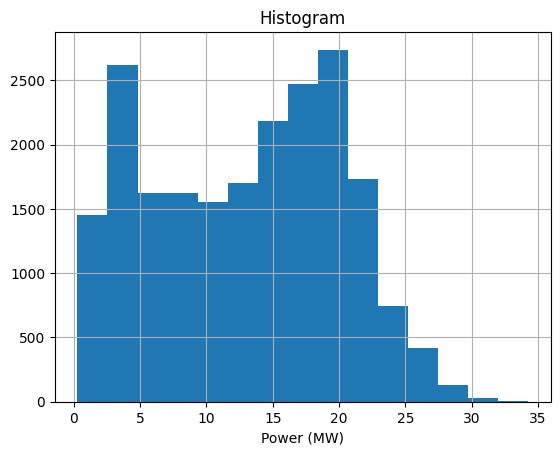

In [29]:
solar["PolyPwr"].hist(bins=15)
plt.xlabel("Power (MW)")
plt.title("Histogram")
plt.show()

We observe that the data does not seem skewed, but there isn't much power output over 30MW. 


We want to study the revelant information and discard any information that will not help us in the prediction. 
This is done thanks to the study of the correlation of the variables, through the correlation matrix. 

<ipython-input-30-7696c1216200>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  solar_corr = solar.corr()
<ipython-input-30-7696c1216200>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(solar.corr(), mask=mask, cmap="YlGnBu", annot=True, fmt=".1f")


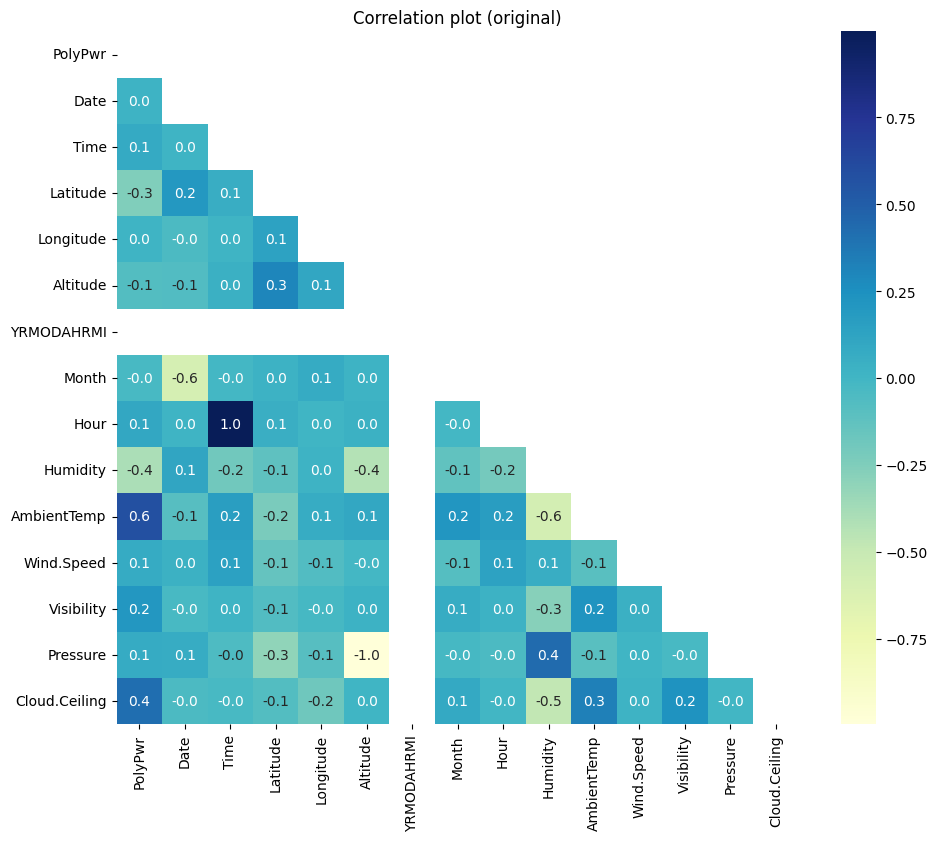

In [30]:
solar_corr = solar.corr()

f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(solar_corr, dtype=bool))

sb.heatmap(solar.corr(), mask=mask, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title("Correlation plot (original)")
plt.show()

We observe from the correlation plot that the variable "YRMODAHRMI" has no correlation to any other variable and was not explained in the dataset so it is dropped. 

The variables that hold the strongest correlation to our target "PolyPwr" are ambient temperature, humidity and cloud ceiling so these must be kept.

Latitude also holds significant correlation but longitude does not, so it is dropped. 
Date, time, hour and month are also dropped because the have very weak, almost no correlation to the target variable.

<ipython-input-31-93203f642044>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  solar_corr = solar.corr()
<ipython-input-31-93203f642044>:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(solar.corr(), mask=mask, cmap="YlGnBu", annot=True, fmt=".1f")


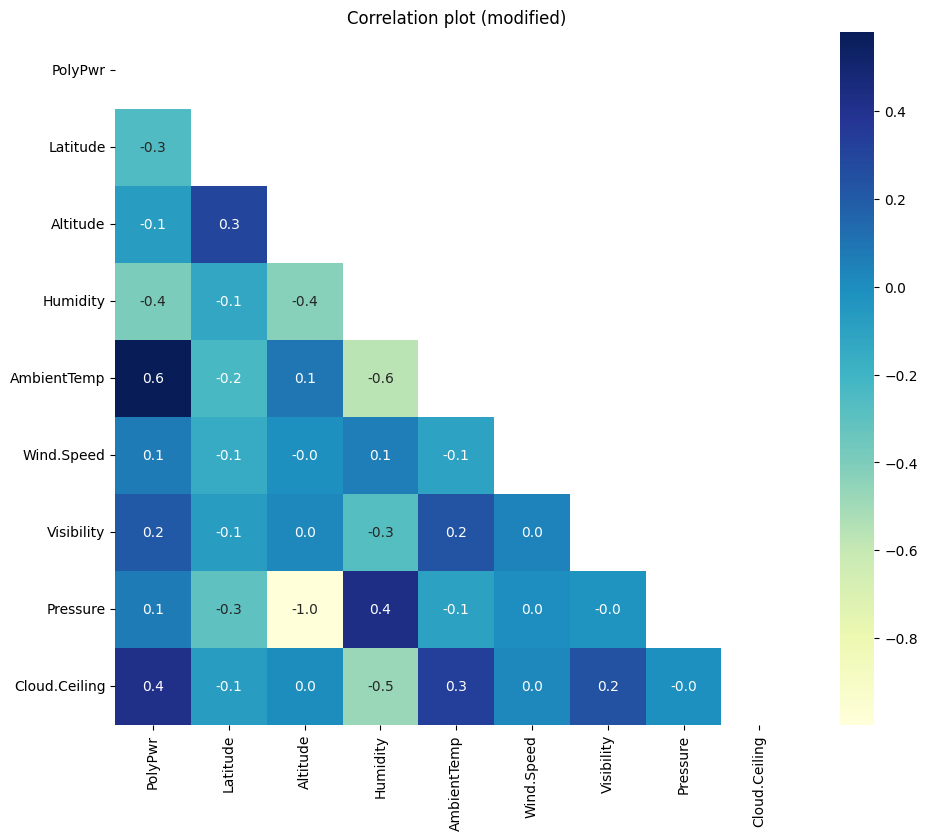

In [31]:
solar.pop("YRMODAHRMI")
solar.pop("Longitude")
solar.pop("Date")
solar.pop("Time")
solar.pop("Hour")
solar.pop("Month")

solar_corr = solar.corr()
f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(solar_corr, dtype=bool))
sb.heatmap(solar.corr(), mask=mask, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title("Correlation plot (modified)")
plt.show()

We need to encode the location and season data, since the data is compiled at different locations over all seasons.
This will allow us to make location and season specific predictions.

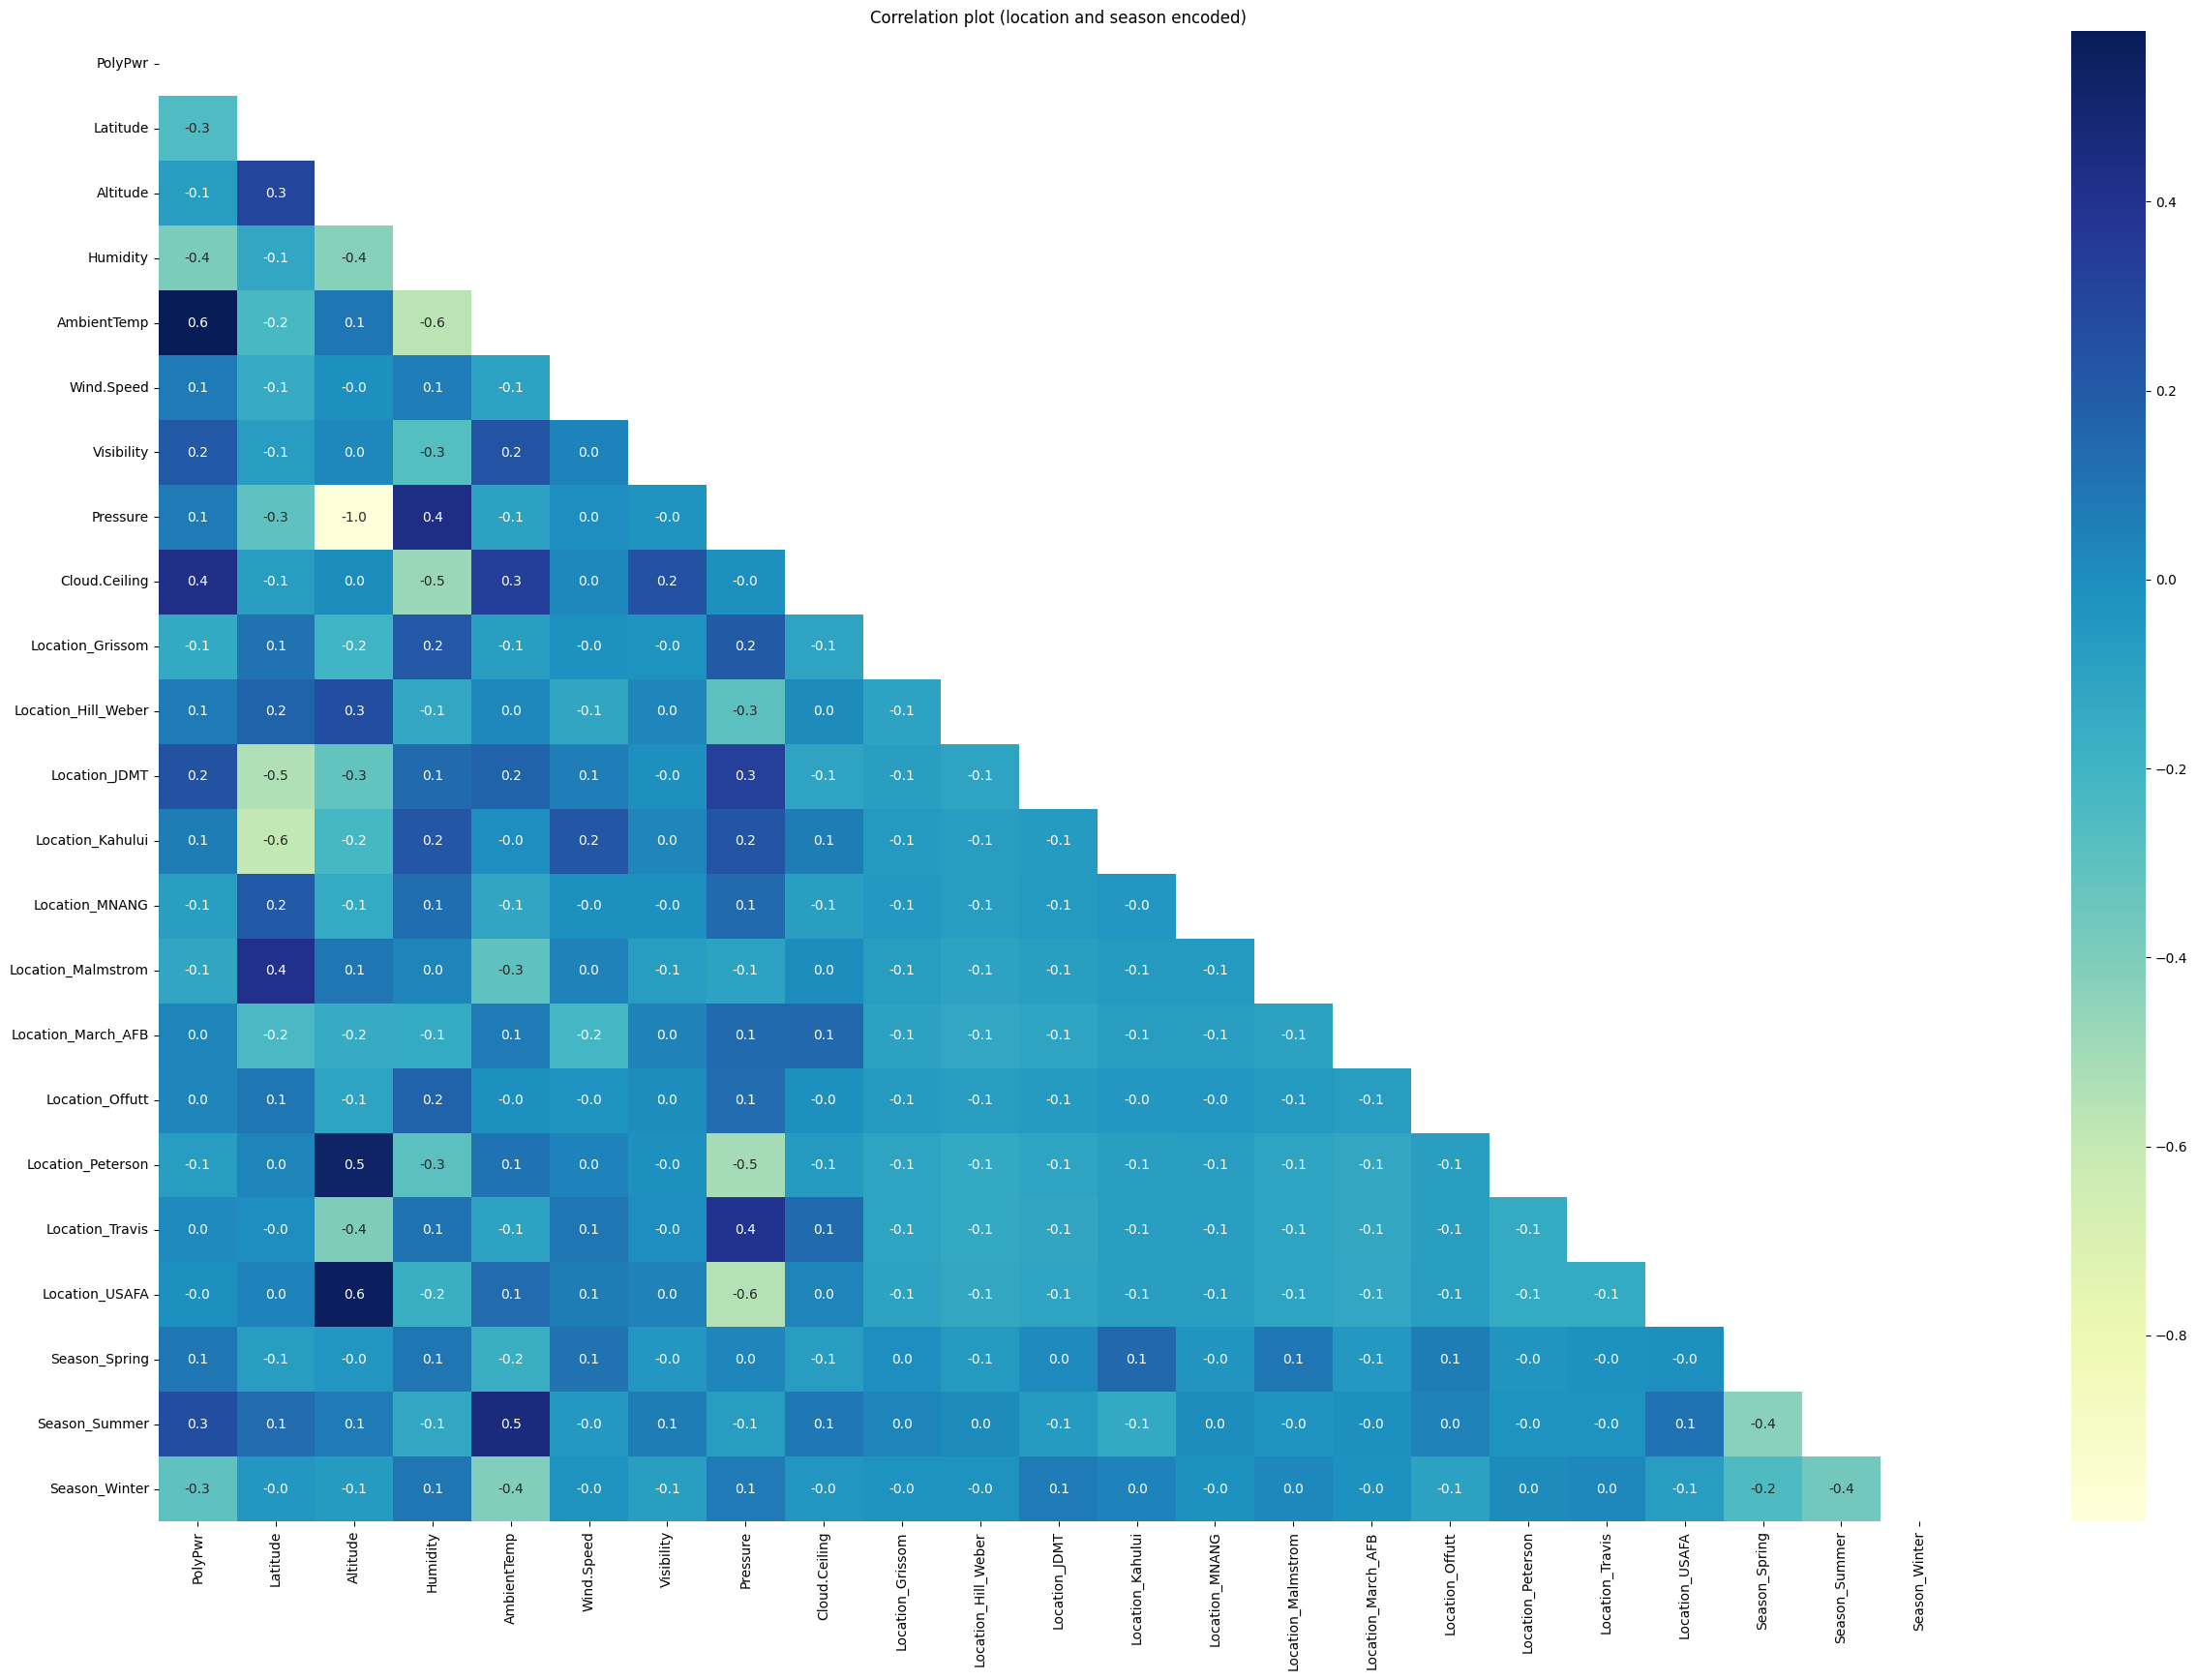

In [32]:
solar_with_location_en = pd.get_dummies(solar, columns=['Location'], drop_first=True)
solar_with_loc_season_en = pd.get_dummies(solar_with_location_en, columns=['Season'], drop_first=True)

mask2 = np.triu(np.ones_like(solar_with_loc_season_en.corr(), dtype=bool))

f, ax = plt.subplots(figsize=(30, 20))
sb.heatmap(solar_with_loc_season_en.corr(), mask=mask2, cmap="YlGnBu", annot=True, fmt='.1f');
plt.title("Correlation plot (location and season encoded)")
plt.show()



# K- Nearest Neighbors (Predefined)
Python has a native KNN regression function, where we only need to load our data set, divide into training and test sets and indicate k (nearest neighbors to make the prediction). We will apply this to use as benchmark, and later develop our own version. 

In [50]:
#We need to reload the raw data to be able to use the regression model. When using the data as me modiifed it before we get some errors. 
url = ("https://raw.githubusercontent.com/anacrm00/Solar/main/Pasion_et_al_dataset2.csv")
solar_df = pd.read_csv(url, header=None)
solar_df.columns = ["Location", "Date", "Time", "Latitude", "Longitude","Altitude","YRMODAHRMI", "Month", "Hour", "Season", "Humidity", 
                 "AmbientTemp","PolyPwr", "Wind.Speed", "Visibility","Pressure", "Cloud.Ceiling"]

solar_df = solar_df.reindex(columns=["PolyPwr","Location", "Date", "Time", "Latitude", "Longitude","Altitude","YRMODAHRMI", "Month", "Hour", "Season", "Humidity", 
                 "AmbientTemp", "Wind.Speed", "Visibility","Pressure", "Cloud.Ceiling"])
solar_df = pd.get_dummies(solar_df)

Splitting the data into training and test sets
> We set 80% of the data for training and 20% for testing

In [51]:
X = solar_df.drop('PolyPwr', axis=1)
y = solar_df['PolyPwr']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Initializing the KNN regressor
> Here we define the number of neighbors that will be used to make the prediction



In [90]:
KNN = KNeighborsRegressor(n_neighbors=6)

Fitting the KNN model to the training set

In [91]:
KNN.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=6)

Now we can make predictions from the testing set

In [92]:
y_pred = KNN.predict(X_test)
df_pred = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
print(df_pred)

         y_true     y_pred
20644  17.84274  17.177188
20802  15.79581  14.880295
6836   11.40692  13.499743
5865   23.09664  12.161175
7628   22.65374  17.177188
...         ...        ...
11244  16.25885  17.177188
2909   21.33986  11.107930
17760  23.81649  17.177188
17936  22.31768  17.177188
19919  17.50188  19.703825

[4209 rows x 2 columns]


We observe that the prediction values are very close to the true value in some cases, but in other cases the prediction is very far from the true value. Because of this, it might be a good idea to calculate the mean square error to evaluate the performance of the model. 

In [93]:
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error: {:.2f}'.format(mse))

Mean squared error: 61.21


Different values of k, produce different errors:

**k =1** | mse = 77.26

**k =2** | mse = 66.36

**k =3** | mse = 52.84

**k =4** | mse = 57.37

**k = 5** | mse = 59.52

**k = 6** | mse = 61.21

# K-Nearest neighbors (Self)